# Download Mgnify analysis results

![MGnify](../assets/figs/mgnify_banner.png)

1. search studies
2. get analyses in a dataframe and save them as `.parquet`
3. compare to local data

In [1]:
# Connection to MGnify API

# this repo is not maintained, or less than jsonapi-requests
# consider a dep change
from jsonapi_client import Session as APISession

# Dataframes and display
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data transformation
from functools import reduce

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline 

# Warning verbosity
import warnings 
warnings.filterwarnings(action="ignore")

## Taxonomy summaries from MGnify studies

In [2]:
TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

# For metadata download
analysisId = 'MGYS00006680'

# local predownloaded MGnify file
ds = {'Sola': 'mgnify_data/SRP237882_taxonomy_abundances_SSU_v5.0.tsv',}

In [3]:
# Data download, and save to file
from urllib.request import urlretrieve
import os

from momics.taxonomy import (
    clean_tax_row,
    fill_taxonomy_placeholders,
    remove_high_taxa,
    pivot_taxonomic_data,
)
from momics.utils import load_and_clean

### Methods

In [4]:
def retrieve_summary(studyId: str, matching_string: str = 'Taxonomic assignments SSU') -> None:
    """
    Retrieve summary data for a given analysis ID and save it to a file. Matching strings 
    are substrings of for instance:
    - Phylum level taxonomies SSU
    - Taxonomic assignments SSU
    - Phylum level taxonomies LSU
    - Taxonomic assignments LSU
    - Phylum level taxonomies ITSoneDB
    - Taxonomic assignments ITSoneDB
    - Phylum level taxonomies UNITE
    - Taxonomic assignments UNITE

    Example usage:
    retrieve_summary('MGYS00006680', matching_string='Taxonomic assignments SSU')

    Args:
        studyId (str): The ID of the analysis to retrieve. studyId is the MGnify study ID, used
            also to save the output .tsv file.
        matching_string (str): The string to match in the download description label.
    
    Returns:
        None
    """
    with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as session:
        for download in session.iterate(f"studies/{studyId}/downloads"):
            if download.description.label == matching_string:
                print(f"Downloading {download.alias}...")
                urlretrieve(download.links.self.url, f'{studyId}.tsv')

# example usage
# retrieve_summary('MGYS00006680', matching_string='Taxonomic assignments SSU')

def pivot_taxonomic_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the taxonomic data (LSU and SSU tables) for analysis. Apart from
    pivoting.

    Normalization of the pivot is optional. Methods include:

    - **None**: no normalization.
    - **tss_sqrt**: Total Sum Scaling and Square Root Transformation.
    - **rarefy**: rarefaction to a specified depth, if None, min of sample sums is used.

    TODO: refactor scaling to a new method and offer different options.

    Args:
        df (pd.DataFrame): The input DataFrame containing taxonomic information.
        normalize (str, optional): Normalization method.
            Options: None, 'tss_sqrt', 'rarefy'. Defaults to None.
        rarefy_depth (int, optional): Depth for rarefaction. If None, uses min sample sum.
            Defaults to None.

    Returns:
        pd.DataFrame: A pivot table with taxonomic data.
    """
    if isinstance(df.index, pd.MultiIndex):
        index = df.index.names[0]
        df1 = df.reset_index()
        df1.set_index(index, inplace=True)
    else:
        df1 = df.copy()

    tax_ranks = [
        'ncbi_tax_id', 'superkingdom', 'kingdom', 'phylum', 'class',
        'order', 'family', 'genus', 'species',
    ]
    prefix_map = {
        "ncbi_tax_id": "",
        "superkingdom": "sk__",
        "kingdom": "k__",
        "phylum": "p__",
        "class": "c__",
        "order": "o__",
        "family": "f__",
        "genus": "g__",
        "species": "s__",
    }
    tax_ranks_filt = [tax for tax in tax_ranks if tax in df1.columns]
    df1["taxonomic_concat"] = df1.apply(
        lambda row: ";" + ";".join(
            f"{prefix_map[tax]}{row[tax]}" if pd.notna(row[tax]) else f"{prefix_map[tax]}"
            for tax in tax_ranks_filt
        ),
        axis=1
    )
    if 'ncbi_tax_id' in tax_ranks_filt:
        pivot_table = (
            df1.pivot_table(
                index=["ncbi_tax_id", "taxonomic_concat"],
                columns=df1.index,
                values="abundance",
            )
            .fillna(0)
            .astype(int)
        )
    else:
        pivot_table = (
            df1.pivot_table(
                index=["taxonomic_concat"],
                columns=df1.index,
                values="abundance",
            )
            .fillna(0)
            .astype(int)
        )
    return pivot_table


def invert_pivot_taxonomic_data(
    pivot: pd.DataFrame,
    drop_zeros: bool = True,
    target_col: str = "taxonomic_concat",
) -> pd.DataFrame:
    """
    Invert the pivot table produced by `pivot_taxonomic_data` back to a long-form table.

    Args:
        pivot (pd.DataFrame): Pivot table with index=['ncbi_tax_id', 'taxonomic_concat']
                             and columns = original sample ids (index values).
        drop_zeros (bool): If True, rows with abundance == 0 are removed. Default True.

    Returns:
        pd.DataFrame: Long-form DataFrame with columns:
                      [sample_col_name, 'ncbi_tax_id', 'taxonomic_concat',
                       'superkingdom','kingdom','phylum','class','order','family','genus','species',
                       'abundance']
    """
    # input checks
    if not isinstance(pivot, pd.DataFrame):
        raise TypeError("pivot must be a pandas DataFrame")


    # Reset index so we have ncbi_tax_id and taxonomic_concat as columns
    reset = pivot.reset_index()
    # reset = pivot.copy()
    # Melt wide -> long
    melted = reset.melt(
        id_vars=[target_col],
        value_vars=[c for c in reset.columns if c != target_col],
        var_name='sample',
        value_name="abundance",
    )

    # Optionally drop zeros
    if drop_zeros:
        melted = melted[melted["abundance"] != 0].copy()

    # Ensure abundance integer type where possible
    try:
        melted["abundance"] = melted["abundance"].astype(int)
    except Exception:
        # fallback to numeric if some values are non-integer
        melted["abundance"] = pd.to_numeric(melted["abundance"], errors="coerce")

    # Parse taxonomic_concat into components.
    # Expected pattern (example):
    # "12345;sk__Archaea;k__...;p__Phylum;c__Class;...;g__Genus;s__Species"
    tax_columns = [
        ("superkingdom", r"sk__"),
        ("kingdom", r"k__"),
        ("phylum", r"p__"),
        ("class", r"c__"),
        ("order", r"o__"),
        ("family", r"f__"),
        ("genus", r"g__"),
        ("species", r"s__"),
    ]

    def parse_tax_concat(s: str):
        # initialize result with empty strings
        res = {col: "" for col, _ in tax_columns}
        if pd.isna(s):
            return res
        # split by ';'
        parts = [p.strip() for p in s.split(";") if p.strip() != ""]
        # first part may be ncbi_tax_id (numeric) - but we rely on explicit ncbi_tax_id column already
        for p in parts:
            for col, prefix in tax_columns:
                if p.startswith(prefix):
                    # remove prefix and use remainder; keep empty if nothing after prefix
                    value = p[len(prefix) :].strip()
                    # normalize empty strings to NaN? Keep as empty string for now
                    res[col] = value
                    break
        return res

    # Apply parser and expand into separate columns
    parsed = melted[target_col].apply(parse_tax_concat)
    parsed_df = pd.DataFrame(parsed.tolist(), index=melted.index)

    result = pd.concat([melted.reset_index(drop=True), parsed_df.reset_index(drop=True)], axis=1)

    # Reorder columns for readability
    cols_order = [
        "sample",
        "abundance",
        "superkingdom",
        "kingdom",
        "phylum",
        "class",
        "order",
        "family",
        "genus",
        "species",
    ]
    # keep only columns that exist (in case some are missing)
    cols_order = [c for c in cols_order if c in result.columns]
    result = result[cols_order]

    # Reset index to a clean integer index
    result = result.reset_index(drop=True)

    return result


def fill_lower_taxa(df: pd.DataFrame, taxonomy_ranks: list) -> pd.DataFrame:
    """
    Fill lower taxonomy ranks with None if the current rank is empty and the lower rank is also empty.
    Starts with the lowest rank and moves upwards.
    
    Args:
        df (pd.DataFrame): DataFrame with taxonomic ranks as columns.
        taxonomy_ranks (list): List of taxonomy rank column names in hierarchical order.

    Returns:
        pd.DataFrame: DataFrame with lower taxonomy ranks filled with None where appropriate.
    """
    df_out = df.copy()
    df_out[taxonomy_ranks[-1]] = df_out[taxonomy_ranks[-1]].replace('', None)
    for i in range(2, len(taxonomy_ranks)):
        lower = taxonomy_ranks[-i + 1]  # lower rank column
        current = taxonomy_ranks[-i]

        df_out[current] = df_out.apply(
        lambda row: None if (row[current] == '' and pd.isna(row[lower])) else row[current],
        axis=1
    )
    return df_out

def aggregate_by_taxonomic_level(df: pd.DataFrame, level: str, dropna: bool = True) -> pd.DataFrame:
    """
    Aggregates the DataFrame by a specific taxonomic level and sums abundances across samples.

    Args:
        df (pd.DataFrame): The input DataFrame containing taxonomic information.
        level (str): The taxonomic level to aggregate by (e.g., 'phylum', 'class', etc.).
        dropna (bool): If True, rows with NaN in the specified level and all higher levels
            are dropped before aggregation. Default is True.

    Returns:
        pd.DataFrame: A DataFrame aggregated by the specified taxonomic level.
    """
    TAXONOMY_RANKS = ['superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
    if level not in df.columns:
        raise KeyError(f"Taxonomic level '{level}' not found in DataFrame")
    
    levels = TAXONOMY_RANKS[:TAXONOMY_RANKS.index(level)+1]

    # working = df if not dropna else df.dropna(subset=[level])
    # working = df if not dropna else df.dropna(subset=levels)
    working = df.copy()

    # Group by the specified level and sum abundances across samples (columns)
    grouped = (
        working
        .groupby([working.index.name, *levels], dropna=dropna)
        .sum(numeric_only=True)
        .reset_index()
        .set_index(working.index.name)
    )
    return grouped

### Get all samples from the study
- Rof the metadata purpose

In [6]:
try:
    samples_meta = pd.read_csv(f'{analysisId}_samples_meta.csv')
except FileNotFoundError:
    print(f"Metadata file not found: Downloading...")

    with APISession("https://www.ebi.ac.uk/metagenomics/api/v1") as session:
        samples_meta = map(lambda r: r.json, session.iterate(f'studies/{analysisId}/analyses'))
        samples_meta = pd.json_normalize(samples_meta)

    samples_meta.to_csv(f'{analysisId}_samples_meta.csv', index=False)

INFO | jsonapi_client.session | Entering session
INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/analyses', params='', query='', fragment='')


Metadata file not found: Downloading...


INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/analyses', params='', query='page=2', fragment='')
INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/analyses', params='', query='page=3', fragment='')
INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/analyses', params='', query='page=4', fragment='')
INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/analyses', params='', query='page=5', fragment='')
INFO | jsonapi_client.session | Fetching document from url ParseResult(scheme='https', netloc='www.ebi.ac.uk', path='/metagenomics/api/v1/studies/MGYS00006680/a

In [8]:
samples_meta.shape

(283, 18)

In [7]:
# samples_meta.groupby('attributes.instrument-model').size().plot(kind='pie')
# plt.title('Number of Analysed Samples by instrument type');

### Load the Mgnify summary table
- This should be concatenation of all the samples from above

In [9]:
root_folder = os.path.abspath(os.path.join('../../'))
assets_folder = os.path.join(root_folder, 'assets')
data_folder = os.path.join(root_folder, 'data')

In [10]:
df_tax_summary = pd.read_csv(os.path.join(data_folder, ds['Sola']), sep='\t')

df_tax_summary.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
df_tax_summary.set_index('taxonomy', inplace=True)
df_tax_summary.head()

,SRR10716830,SRR10716840,SRR10716850,SRR10716860,SRR10716870,SRR10716880,SRR10716890,SRR10716900,SRR10716910,SRR10716920,SRR10716930,SRR10716940,SRR10716950,SRR10716960,SRR10716970,SRR10716980,SRR10716990,SRR10717000,SRR10717010,SRR10717020,SRR10717030,SRR10717040,SRR10717050,SRR10717060,SRR10717070,SRR10717080,SRR10717090,SRR10717100,SRR10716821,SRR10716831,SRR10716841,SRR10716851,SRR10716861,SRR10716871,SRR10716881,SRR10716891,SRR10716901,SRR10716911,SRR10716921,SRR10716931,SRR10716941,SRR10716951,SRR10716961,SRR10716971,SRR10716981,SRR10716991,SRR10717001,SRR10717011,SRR10717021,SRR10717031,SRR10717041,SRR10717051,SRR10717061,SRR10717071,SRR10717081,SRR10717091,SRR10717101,SRR10716822,SRR10716832,SRR10716842,SRR10716852,SRR10716862,SRR10716872,SRR10716882,SRR10716892,SRR10716902,SRR10716912,SRR10716922,SRR10716932,SRR10716942,SRR10716952,SRR10716962,SRR10716972,SRR10716982,SRR10716992,SRR10717002,SRR10717012,SRR10717022,SRR10717032,SRR10717042,SRR10717052,SRR10717062,SRR10717072,SRR10717082,SRR10717092,SRR10717102,SRR10716823,SRR10716833,SRR10716843,SRR10716853,SRR10716863,SRR10716873,SRR10716883,SRR10716893,SRR10716903,SRR10716913,SRR10716923,SRR10716933,SRR10716943,SRR10716953,SRR10716963,SRR10716973,SRR10716983,SRR10716993,SRR10717003,SRR10717013,SRR10717023,SRR10717033,SRR10717043,SRR10717053,SRR10717063,SRR10717073,SRR10717083,SRR10717093,SRR10717103,SRR10716824,SRR10716834,SRR10716844,SRR10716854,SRR10716864,SRR10716874,SRR10716884,SRR10716894,SRR10716904,SRR10716914,SRR10716924,SRR10716934,SRR10716944,SRR10716954,SRR10716964,SRR10716974,SRR10716984,SRR10716994,SRR10717004,SRR10717014,SRR10717024,SRR10717034,SRR10717044,SRR10717054,SRR10717064,SRR10717074,SRR10717084,SRR10717094,SRR10716825,SRR10716835,SRR10716845,SRR10716855,SRR10716865,SRR10716875,SRR10716885,SRR10716895,SRR10716905,SRR10716915,SRR10716925,SRR10716935,SRR10716945,SRR10716955,SRR10716965,SRR10716975,SRR10716985,SRR10716995,SRR10717005,SRR10717015,SRR10717025,SRR10717035,SRR10717045,SRR10717055,SRR10717065,SRR10717075,SRR10717085,SRR10717095,SRR10716826,SRR10716836,SRR10716846,SRR10716856,SRR10716866,SRR10716876,SRR10716886,SRR10716896,SRR10716906,SRR10716916,SRR10716926,SRR10716936,SRR10716946,SRR10716956,SRR10716966,SRR10716976,SRR10716986,SRR10716996,SRR10717006,SRR10717016,SRR10717026,SRR10717036,SRR10717046,SRR10717056,SRR10717066,SRR10717076,SRR10717086,SRR10717096,SRR10716827,SRR10716837,SRR10716847,SRR10716857,SRR10716867,SRR10716877,SRR10716887,SRR10716897,SRR10716907,SRR10716917,SRR10716927,SRR10716937,SRR10716947,SRR10716957,SRR10716967,SRR10716977,SRR10716987,SRR10716997,SRR10717007,SRR10717017,SRR10717027,SRR10717037,SRR10717047,SRR10717057,SRR10717067,SRR10717077,SRR10717087,SRR10717097,SRR10716828,SRR10716838,SRR10716848,SRR10716858,SRR10716868,SRR10716878,SRR10716888,SRR10716898,SRR10716908,SRR10716918,SRR10716928,SRR10716938,SRR10716948,SRR10716958,SRR10716968,SRR10716978,SRR10716988,SRR10716998,SRR10717008,SRR10717018,SRR10717028,SRR10717038,SRR10717048,SRR10717058,SRR10717068,SRR10717078,SRR10717088,SRR10717098,SRR10716829,SRR10716839,SRR10716849,SRR10716859,SRR10716869,SRR10716879,SRR10716889,SRR10716899,SRR10716909,SRR10716919,SRR10716929,SRR10716939,SRR10716949,SRR10716959,SRR10716969,SRR10716979,SRR10716989,SRR10716999,SRR10717009,SRR10717019,SRR10717029,SRR10717039,SRR10717049,SRR10717059,SRR10717069,SRR10717079,SRR10717089,SRR10717099
taxonomy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sk__Archaea,0,0,0,0,0,0,0,1,8,0,16,2,0,4,3,7,2,2,0,0,1,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,6,9,3,0,1,1,2,2,13,10,3,0,1,0,13,8,0,0,0,0,0,0,0,0,0,0,0,0,0,9,13,7,8,0,2,0,3,0,0,0,2,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,10,3,3,0,1,4,2,4,4,2,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,7,0,3,0,1,3,12,0,1,1,5,0,0,0,0,0,0,0,0,0

In [11]:
# assertions to ensure data integrity
assert len(df_tax_summary[df_tax_summary.index=='sk__Archaea']) == 1, f"There should be exactly one row with Archea, but found {len(df_tax_summary[df_tax_summary.index=='sk__Archea'])}"
assert len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota']) == 1, f"There should be exactly one row with Eukaryota, but found {len(df_tax_summary[df_tax_summary.index=='sk__Eukaryota'])}"

# asserts to ensure data integrity
assert samples_meta['relationships.sample.data.id'].size == len(df_tax_summary.columns)
lst1 = samples_meta['relationships.run.data.id'].tolist()
lst2 = df_tax_summary.columns.tolist()
lst1.sort(), lst2.sort()
assert lst1 == lst2

del lst1, lst2

These are the total number of reads annotated

In [17]:
abundance_sums = df_tax_summary.iloc[:,:].apply(sum, axis=0)
# abundance_sums.head()

In [20]:
long_df = invert_pivot_taxonomic_data(df_tax_summary, target_col='taxonomy')
# long_df.head()

In [21]:
# this fails and should be reported to the EBI MGnify team
# for sample in samples_meta['relationships.run.data.id'].to_list():
#     lst = samples_meta[samples_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
#     df_tmp = pd.DataFrame(lst)
#     assert (long_df[long_df['sample']==sample]['abundance'].sum() == 
#             int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0])), f"Sum mismatch for sample {sample}, {df1.tail(2)}, \
#     {long_df[long_df['sample']==sample]['abundance'].sum()} \
#     {abundance_sums[sample]}"


# this is just an internal check, external one is above and failing
for sample in samples_meta['relationships.run.data.id'].to_list():
    assert long_df[long_df['sample']==sample]['abundance'].sum() == df_tax_summary[sample].sum()

In [22]:
# Fill lower taxa with None
long_df = fill_lower_taxa(long_df, TAXONOMY_RANKS)

# Placeholders for missing taxa to be able to map on certain taxon and to be able to rarefy
long_df = fill_taxonomy_placeholders(long_df, TAXONOMY_RANKS)

In [23]:
dropna = False   # setting for aggregation
level = 'phylum'  # setting for aggregation
# removing high taxa is basically running `aggregate_by_taxonomic_level` with dropna option
long_df_indexed = long_df.set_index('sample')
long_df_filt = aggregate_by_taxonomic_level(long_df_indexed, level='phylum', dropna=dropna)

In [24]:
# asserts
if not dropna:
    assert long_df['abundance'].sum() == long_df_filt['abundance'].sum()

    for sample in samples_meta['relationships.run.data.id'].to_list():
        assert long_df[long_df['sample']==sample]['abundance'].sum() == long_df_filt[long_df_filt.index==sample]['abundance'].sum(), f"Sum mismatch for sample {sample}"

remove high taxa without grouping

In [25]:
print("Original DataFrame shape:", long_df.shape)
long_df_dropna = remove_high_taxa(long_df, taxonomy_ranks=TAXONOMY_RANKS, tax_level='phylum', strict=False)
print("Filtered DataFrame shape:", long_df_dropna.shape)

INFO | momics.taxonomy | RETURN:         sample  abundance superkingdom  \
1  SRR10716830        625    Eukaryota   
2  SRR10716830          1    Eukaryota   
3  SRR10716830          2    Eukaryota   
4  SRR10716830         50    Eukaryota   
5  SRR10716830         30    Eukaryota   

                                              kingdom  \
1     unclassified_unclassified_unclassified_Jakobida   
2  unclassified_unclassified_unclassified_Pirsoniales   
3  unclassified_unclassified_unclassified_Pirsoniales   
4   unclassified_unclassified_unclassified_Telonemida   
5                    unclassified_unclassified_Bigyra   

                                  phylum                     class  \
1     unclassified_unclassified_Jakobida     unclassified_Jakobida   
2  unclassified_unclassified_Pirsoniales  unclassified_Pirsoniales   
3  unclassified_unclassified_Pirsoniales  unclassified_Pirsoniales   
4   unclassified_unclassified_Telonemida   unclassified_Telonemida   
5                    

Original DataFrame shape: (79937, 10)
Filtered DataFrame shape: (78956, 10)


### Pivot back

In [26]:
try:
    long_df.set_index('sample', inplace=True)
except Exception as e:
    print(f"Indexing error: {e}")
df_pivot = pivot_taxonomic_data(long_df)
# df_pivot.head()

In [27]:
df_filt_pivot = pivot_taxonomic_data(long_df_filt)
# df_filt_pivot.head()

## Rarefaction per sample

### Magnify

In [28]:
import numpy as np


def rarefaction_curve(reads, steps=20, replicates=10):
    depths = np.linspace(1, len(reads), steps, dtype=int)
    richness = []
    for n in depths:
        reps = []
        for _ in range(replicates):
            subsample = np.random.choice(reads, size=n, replace=False)
            reps.append(len(np.unique(subsample)))
        richness.append(np.mean(reps))
    return depths, richness

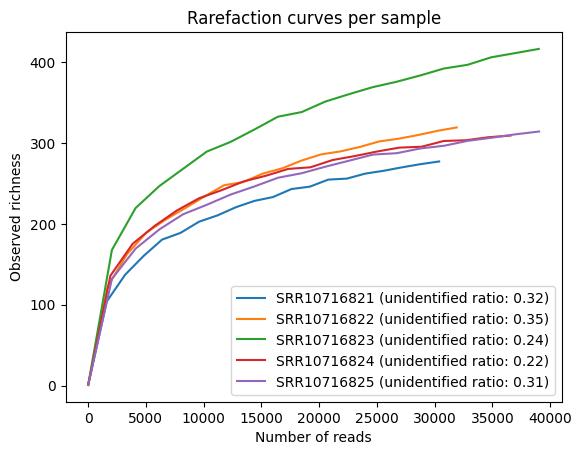

In [29]:
abund_table = df_pivot.copy()

for sample in abund_table.columns[:5]:
    lst = samples_meta[samples_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
    df_tmp = pd.DataFrame(lst)
    total = int(df_tmp[df_tmp['key']=='Submitted nucleotide sequences']['value'].values[0])
    identified = (int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0]) + 
                  int(df_tmp[df_tmp['key']=='Predicted LSU sequences']['value'].values[0]))
    ratio = (total - identified) / total
    reads = np.repeat(abund_table.index, abund_table[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=f'{sample} (unidentified ratio: {ratio:.2f})')

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()

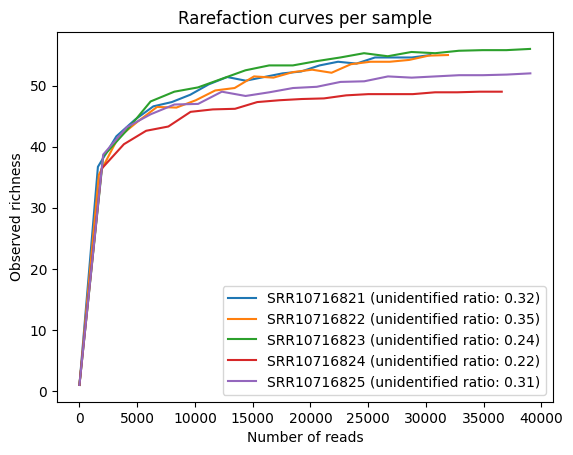

In [30]:
abund_table = df_filt_pivot.copy()

for sample in abund_table.columns[:5]:
    lst = samples_meta[samples_meta['relationships.run.data.id']==sample]['attributes.analysis-summary'].values[0]
    df_tmp = pd.DataFrame(lst)
    total = int(df_tmp[df_tmp['key']=='Submitted nucleotide sequences']['value'].values[0])
    identified = (int(df_tmp[df_tmp['key']=='Predicted SSU sequences']['value'].values[0]) + 
                  int(df_tmp[df_tmp['key']=='Predicted LSU sequences']['value'].values[0]))
    ratio = (total - identified) / total
    reads = np.repeat(abund_table.index, abund_table[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=f'{sample} (unidentified ratio: {ratio:.2f})')

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()

### EMO-BON
- here again taking simply number of reads mapped, not the total reads
- should be scaled by the total reads?

In [43]:
emobon_folder = os.path.abspath(os.path.join('../../data'))
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(emobon_folder, 'shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [44]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

In [45]:
# keep only taxonomy
ssu = mgf_parquet_dfs['ssu'].copy()
lsu = mgf_parquet_dfs['lsu'].copy()

del mgf_parquet_dfs

In [ ]:
def process_taxonomy(df, TAXONOMY_RANKS):
    df_filt = fill_taxonomy_placeholders(df, TAXONOMY_RANKS)
    df_filt = pivot_taxonomic_data(df_filt)


# unify taxonomic information to the MGnify
    df_filt = df_filt.reset_index()
    df_filt['taxonomic_concat'] = df_filt['taxonomic_concat'].apply(clean_tax_row)

# unify column and index names
    df_filt = df_filt.set_index('ncbi_tax_id')
    df_filt = df_filt.rename(columns={
    'taxonomic_concat': '#SampleID',
})
    df_filt.rename(columns={'#SampleID': 'taxonomy'}, inplace=True)
    df_filt.set_index('taxonomy', inplace=True)
    df_filt.head()
    return df_filt

ssu_filt = process_taxonomy(ssu, TAXONOMY_RANKS)
lsu_filt = process_taxonomy(lsu, TAXONOMY_RANKS)
ssu_filt.head()

source material ID,EMOBON_AAOT_Wa_1,EMOBON_AAOT_Wa_2,EMOBON_AAOT_Wa_22,EMOBON_AAOT_Wa_26,EMOBON_AAOT_Wa_27,EMOBON_AAOT_Wa_41,EMOBON_AAOT_Wa_42,EMOBON_AAOT_Wa_46,EMOBON_AAOT_Wa_47,EMOBON_AAOT_Wa_6,EMOBON_AAOT_Wa_61,EMOBON_AAOT_Wa_62,EMOBON_AAOT_Wa_66,EMOBON_AAOT_Wa_67,EMOBON_AAOT_Wa_7,EMOBON_BPNS_So_13,EMOBON_BPNS_So_17,EMOBON_BPNS_So_18,EMOBON_BPNS_So_33,EMOBON_BPNS_So_34,EMOBON_BPNS_So_5,EMOBON_BPNS_So_6,EMOBON_BPNS_Wa_1,EMOBON_BPNS_Wa_2,EMOBON_BPNS_Wa_21,EMOBON_BPNS_Wa_22,EMOBON_BPNS_Wa_26,EMOBON_BPNS_Wa_27,EMOBON_BPNS_Wa_41,EMOBON_BPNS_Wa_42,EMOBON_BPNS_Wa_46,EMOBON_BPNS_Wa_47,EMOBON_BPNS_Wa_6,EMOBON_BPNS_Wa_61,EMOBON_BPNS_Wa_62,EMOBON_BPNS_Wa_66,EMOBON_BPNS_Wa_67,EMOBON_BPNS_Wa_7,EMOBON_EMT21_Wa_1,EMOBON_EMT21_Wa_16,EMOBON_EMT21_Wa_17,EMOBON_EMT21_Wa_2,EMOBON_EMT21_Wa_21,EMOBON_EMT21_Wa_22,EMOBON_EMT21_Wa_31,EMOBON_EMT21_Wa_32,EMOBON_EMT21_Wa_36,EMOBON_EMT21_Wa_37,EMOBON_EMT21_Wa_6,EMOBON_EMT21_Wa_7,EMOBON_ESC68N_Wa_1,EMOBON_ESC68N_Wa_11,EMOBON_ESC68N_Wa_14,EMOBON_ESC68N_Wa_2,EMOBON_ESC68N_Wa_3,EMOBON_ESC68N_Wa_4,EMOBON_HCMR-1_Wa_1,EMOBON_HCMR-1_Wa_5,EMOBON_HCMR-1_Wa_6,EMOBON_IUIEilat_Wa_1,EMOBON_IUIEilat_Wa_11,EMOBON_IUIEilat_Wa_12,EMOBON_IUIEilat_Wa_15,EMOBON_IUIEilat_Wa_16,EMOBON_IUIEilat_Wa_2,EMOBON_IUIEilat_Wa_21,EMOBON_IUIEilat_Wa_22,EMOBON_IUIEilat_Wa_25,EMOBON_IUIEilat_Wa_26,EMOBON_IUIEilat_Wa_5,EMOBON_IUIEilat_Wa_6,EMOBON_MBAL4_Wa_1,EMOBON_MBAL4_Wa_11,EMOBON_MBAL4_Wa_12,EMOBON_MBAL4_Wa_13,EMOBON_MBAL4_Wa_14,EMOBON_MBAL4_Wa_2,EMOBON_MBAL4_Wa_3,EMOBON_MBAL4_Wa_4,EMOBON_NRMCB_So_1,EMOBON_NRMCB_So_11,EMOBON_NRMCB_So_12,EMOBON_NRMCB_So_16,EMOBON_NRMCB_So_17,EMOBON_NRMCB_So_2,EMOBON_NRMCB_So_6,EMOBON_NRMCB_So_7,EMOBON_NRMCB_Wa_1,EMOBON_NRMCB_Wa_2,EMOBON_NRMCB_Wa_23,EMOBON_NRMCB_Wa_24,EMOBON_NRMCB_Wa_28,EMOBON_NRMCB_Wa_29,EMOBON_NRMCB_Wa_43,EMOBON_NRMCB_Wa_44,EMOBON_NRMCB_Wa_48,EMOBON_NRMCB_Wa_49,EMOBON_NRMCB_Wa_63,EMOBON_NRMCB_Wa_64,EMOBON_NRMCB_Wa_68,EMOBON_NRMCB_Wa_69,EMOBON_OOB_So_1,EMOBON_OOB_So_25,EMOBON_OOB_So_26,EMOBON_OSD74_Wa_1,EMOBON_OSD74_Wa_11,EMOBON_OSD74_Wa_12,EMOBON_OSD74_Wa_13,EMOBON_OSD74_Wa_14,EMOBON_OSD74_Wa_2,EMOBON_OSD74_Wa_21,EMOBON_OSD74_Wa_22,EMOBON_OSD74_Wa_23,EMOBON_OSD74_Wa_24,EMOBON_OSD74_Wa_4,EMOBON_PiEGetxo_Wa_1,EMOBON_PiEGetxo_Wa_12,EMOBON_PiEGetxo_Wa_13,EMOBON_PiEGetxo_Wa_14,EMOBON_PiEGetxo_Wa_15,EMOBON_PiEGetxo_Wa_2,EMOBON_PiEGetxo_Wa_3,EMOBON_PiEGetxo_Wa_4,EMOBON_PiEGetxo_Wa_48,EMOBON_PiEGetxo_Wa_49,EMOBON_PiEGetxo_Wa_50,EMOBON_PiEGetxo_Wa_51,EMOBON_RFormosa_So_1,EMOBON_RFormosa_So_11,EMOBON_RFormosa_So_12,EMOBON_RFormosa_So_2,EMOBON_RFormosa_So_6,EMOBON_RFormosa_So_7,EMOBON_RFormosa_Wa_1,EMOBON_RFormosa_Wa_11,EMOBON_RFormosa_Wa_12,EMOBON_RFormosa_Wa_15,EMOBON_RFormosa_Wa_16,EMOBON_RFormosa_Wa_2,EMOBON_RFormosa_Wa_21,EMOBON_RFormosa_Wa_22,EMOBON_RFormosa_Wa_25,EMOBON_RFormosa_Wa_26,EMOBON_RFormosa_Wa_5,EMOBON_RFormosa_Wa_6,EMOBON_ROSKOGO_So_1,EMOBON_ROSKOGO_So_16,EMOBON_ROSKOGO_So_17,EMOBON_ROSKOGO_So_2,EMOBON_ROSKOGO_So_21,EMOBON_ROSKOGO_So_22,EMOBON_ROSKOGO_Wa_1,EMOBON_ROSKOGO_Wa_13,EMOBON_ROSKOGO_Wa_14,EMOBON_ROSKOGO_Wa_17,EMOBON_ROSKOGO_Wa_18,EMOBON_ROSKOGO_Wa_2,EMOBON_ROSKOGO_Wa_23,EMOBON_ROSKOGO_Wa_24,EMOBON_ROSKOGO_Wa_27,EMOBON_ROSKOGO_Wa_28,EMOBON_ROSKOGO_Wa_33,EMOBON_ROSKOGO_Wa_34,EMOBON_ROSKOGO_Wa_37,EMOBON_ROSKOGO_Wa_38,EMOBON_VB_Wa_1,EMOBON_VB_Wa_137,EMOBON_VB_Wa_138,EMOBON_VB_Wa_140,EMOBON_VB_Wa_141,EMOBON_VB_Wa_2,EMOBON_VB_Wa_4,EMOBON_VB_Wa_41,EMOBON_VB_Wa_42,EMOBON_VB_Wa_43,EMOBON_VB_Wa_44,EMOBON_VB_Wa_5,EMOBON_VB_Wa_93,EMOBON_VB_Wa_94,EMOBON_VB_Wa_96,EMOBON_VB_Wa_97
taxonomy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
;sk__Bacteria,1256,1783,1920,895,536,848,461,534,304,1172,1323,2047,783,766,936,149,368,586,373,281,86,69,4046,4058,1663,2349,356,439,872,977,450,572,407,802,818,831,985,435,2107,1182,1169,1925,537,577,1642,3091,2015,1601,217,227,644,976,248,824,798,799,660,616,577,1512,1935,2011,372,404,1761,1310,1763,1012,372,417,444,144

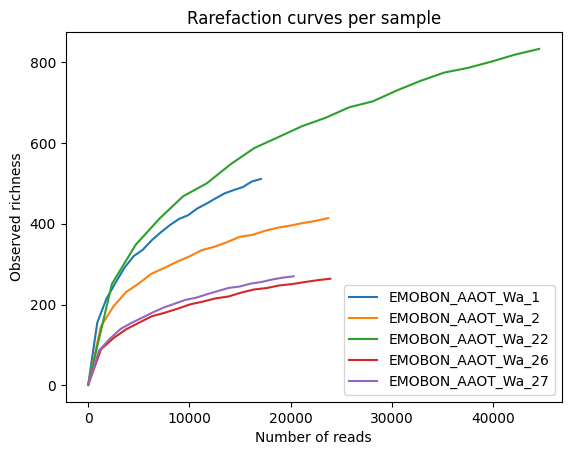

In [47]:
abund_emobon = ssu_filt.copy()

for sample in abund_emobon.columns[:5]:
    reads = np.repeat(abund_emobon.index, abund_emobon[sample].values)
    depths, richness = rarefaction_curve(reads)
    plt.plot(depths, richness, label=sample)

plt.legend()
plt.xlabel("Number of reads")
plt.ylabel("Observed richness")
plt.title("Rarefaction curves per sample")
plt.show()